In [1]:
import pandas as pd

from src.SemEvalData import SemEvalData
from src.JigsawData import JigsawData
from nltk import tokenize
import nltk
from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.callbacks import Callback, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding, Input, Dense, LSTM, GRU, Bidirectional, TimeDistributed, Dropout
from keras import backend as K
from keras import optimizers
from keras.models import Model
from src.Attention import Attention
import re
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score
from src.preprocessing import get_embeddings_index, get_embeddings_matrix

In [2]:
##set to .env
MAX_FEATURES = 200000 # maximum number of unique words that should be included in the tokenized word index
MAX_WORD_NUM = 100     # maximum number of letters in sentence?
EMBED_SIZE = 300  ## same value as in dimension of glove
VAL_SPLIT = 0.2  
REG_PARAM = 1e-13
l2_reg = regularizers.l2(REG_PARAM)

In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Julia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
## load data
train_data_semeval = SemEvalData(MAX_WORD_NUM)
data = train_data_semeval.load_data("data/tsd_trial.csv")
train_df_preprocessed = train_data_semeval.preprocess()

# extra_train = JigsawData(MAX_WORD_NUM)
# extra_train.load_data("data/train.csv")
# extra_df_preprocessed = extra_train.preprocess()


In [9]:
print(train_df_preprocessed)
#print(extra_df_preprocessed)
print(train_data_semeval.get_missing_class_elements(train_df_preprocessed, 10, [0.0]))

                                                 spans  \
0             [15, 16, 17, 18, 19, 27, 28, 29, 30, 31]   
1                             [29, 30, 31, 32, 33, 34]   
2                       [166, 167, 168, 169, 170, 171]   
3                             [87, 88, 89, 90, 91, 92]   
4                                                   []   
..                                                 ...   
685                     [129, 130, 131, 132, 133, 134]   
686                     [126, 127, 128, 129, 130, 131]   
687                           [24, 25, 26, 27, 28, 29]   
688  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
689                     [136, 137, 138, 139, 140, 141]   

                                                  text  toxicity  \
0    because hes a moron and a bigot its not any mo...         1   
1    how about we stop protecting idiots and let na...         1   
2    if people  were  smart they would  boycott thi...         1   
3    trump claimed that russia 

ValueError: ('Lengths must match to compare', (690,), (1,))

In [7]:
paras = []
labels = []
texts = []
sent_lens = []
sent_nums = []

##tokenize words
len_tr = len(train_df_preprocessed)
# result = train_df_preprocessed.append(extra_train_df, ignore_index=True, sort=False)
result = train_df_preprocessed
train_data = {
    'sentence':  result.sentences.sum(),
    'toxicity_sentence': result.toxicity_sentence.sum()
        }

train_df = pd.DataFrame (train_data, columns = ['sentence','toxicity_sentence'])
###


In [8]:
train_df

,sentence,toxicity_sentence
0,another violent and aggressive immigrant killi...,1.0
1,i am years old i am not your fucking junior p...,1.0
2,damn a whole family sad indeed,1.0
3,what a knucklehead how can anyone not know thi...,1.0
4,who do you think should do the killing anyone...,1.0
...,...,...
7934,another fool pipes in,1.0
7935,so if a restaurant owner puts up a sign saying...,1.0
7936,any faith that cant stand up to logic and reas...,1.0
7937,this idiotic use the surplus to pay down the p...,1.0


In [9]:
sentences =[]
for i in train_df.sentence:
    sentences.append(nltk.word_tokenize(i))

In [10]:
#filter token that are not alphabetic
sentences_filter=[]
for i, w in enumerate(sentences):
    sentences[i] = [word for word in sentences[i] if word.isalpha()]

In [11]:
#filter stop words
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
for i, w in enumerate(sentences):
    sentences[i] = [w for w in sentences[i] if not w in stop_words]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Julia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
tokenizer = Tokenizer(num_words=MAX_FEATURES,lower=True, split=" ")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
word_counts = tokenizer.word_counts

In [15]:
import gensim
word_vectors = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True, limit = 1000000) 

In [22]:
EMBEDDING_DIM = 300
vocabulary_size=min(len(word_index)+1,MAX_FEATURES)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))

In [23]:
absent_words =0
for word, i in word_index.items():
    if i>=MAX_FEATURES:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)
        absent_words+=1

In [18]:
data_index = np.zeros((len(sentences), MAX_WORD_NUM), dtype='int32')
for i, sentence in enumerate(sentences):
    for k, word in enumerate(sentence):
        try:
            if k<MAX_WORD_NUM and tokenizer.word_index[word]<MAX_FEATURES:
                data_index[i,k] = tokenizer.word_index[word]
        except:
            #print(word)
            pass

NameError: name 'get_embeddings_index' is not defined

In [11]:
sentences = [x for x in sentences if x!=[]]

In [20]:
print(data_index[:5])
indices = np.arange(data_index.shape[0])
np.random.shuffle(indices)
data = data_index[indices].copy()
##IMPORTANT
data = data.astype(np.float32)
labels = train_df.toxicity_sentence.iloc[indices]
# labels = labels.astype(np.float32)
nb_validation_samples = int(VAL_SPLIT * data.shape[0])
x_train = data[:-nb_validation_samples]
y_train = np.vstack(labels[:-nb_validation_samples])
x_val = data[-nb_validation_samples:]
y_val = np.vstack(labels[-nb_validation_samples:])

[[  36 1131 3048 1913  295  658  869   10  972 3395    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  48  146  659 2549 1292  165  120  387    6   12 9767 1242  127  619
    72   64  311 2792 9768   22  407  741 9769 9770   64 1433   64  147
  5416   52   44   20  839  439  514  619  103  515   65  514 1132  440
   514  619 2029 1293 6916  259 1186 9771 9772 3844 6916  367   54  162
   812   20 2550  514  619 1009    6   18 9773 1689  553  368    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0

In [27]:
embedding_layer = Embedding(len(word_index)+1 ,EMBED_SIZE,weights=[embedding_matrix], input_length=MAX_WORD_NUM, trainable= True, name='embedding')
word_input = Input(shape=MAX_WORD_NUM, dtype='float32', name='input')
word_sequences = embedding_layer(word_input)
word_lstm = Bidirectional(LSTM(40, return_sequences=True, kernel_regularizer=l2_reg), name='bidirectional')(word_sequences)
word_dense = Dense(70, kernel_regularizer=l2_reg, name='dense')(word_lstm)
word_att = Dropout(0.2)(Attention(name='attention')(word_dense))#
preds = Dense(1, activation='relu', name='dense_final')(word_att) ##softmax, elu?
model = Model(word_input, preds)
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['acc']) ##adam
checkpoint = ModelCheckpoint('best_model_embeddings.h5', verbose=-2, monitor='val_loss',save_best_only=True, mode='auto')
print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 300)          6054600   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 80)           109120    
_________________________________________________________________
dense (Dense)                (None, 100, 70)           5670      
_________________________________________________________________
attention (Attention)        (None, 70)                5040      
_________________________________________________________________
dropout (Dropout)            (None, 70)                0         
_________________________________________________________________
dense_final (Dense)          (None, 1)                

Epoch 1/5
25/25 [==============================] - 33s 1s/step - loss: 0.9483 - acc: 0.9378 - val_loss: 0.8744 - val_acc: 0.9427
Epoch 2/5
25/25 [==============================] - 32s 1s/step - loss: 0.9483 - acc: 0.9378 - val_loss: 0.8744 - val_acc: 0.9427
Epoch 3/5
25/25 [==============================] - 34s 1s/step - loss: 0.9483 - acc: 0.9378 - val_loss: 0.8744 - val_acc: 0.9427
Epoch 4/5
25/25 [==============================] - 34s 1s/step - loss: 0.9483 - acc: 0.9378 - val_loss: 0.8744 - val_acc: 0.9427
Epoch 5/5
25/25 [==============================] - 36s 1s/step - loss: 0.9483 - acc: 0.9378 - val_loss: 0.8744 - val_acc: 0.9427
dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


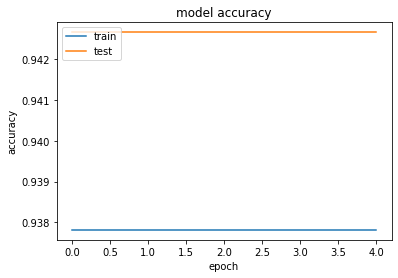

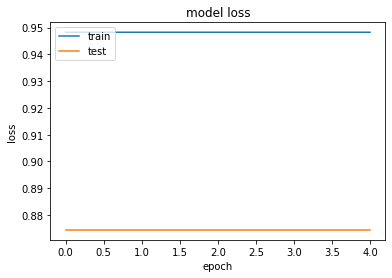

In [29]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=256,shuffle=True, callbacks=[checkpoint])
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

model.save('best_model_embeddings.h5')


In [30]:
def wordAttentionWeights(sequenceSentence,weights):
    """
    The same function as the AttentionLayer class.
    """
    uit = np.dot(sequenceSentence, weights[0]) + weights[1]
    uit = np.tanh(uit)

    ait = np.dot(uit, weights[2])
    ait = np.squeeze(ait)
    ait = np.exp(ait)
    ait /= np.sum(ait)
    
    return ait


# Create model from word input to output of dense layer right before the attention layer
# print( model.get_layer('time_distributed').output.shape,  len(model.get_layer('dense_final').get_weights()))
hidden_word_encoding_out = Model(inputs=model.input, outputs= model.get_layer('dense').output)
# Load weights from trained attention layer
word_context = model.get_layer('attention').get_weights()
# hidden_word_encodings = hidden_word_encoding_out.predict(word_input_array)
# # Compute context vector using output of dense layer
# ait = wordAttentionWeights(hidden_word_encodings,word_context)

In [32]:
for i in range(0,20):
    #print('data',data[i])
    in_data =data_index[i].reshape(1,MAX_WORD_NUM)
    y = model.predict(in_data)
    print('result:',y, in_data,train_df.iloc[i].toxicity_sentence)
    print('row:',len(train_df.iloc[i].sentence),train_df.iloc[i].sentence)
    hidden_word_encodings = hidden_word_encoding_out.predict(in_data)
     # Compute context vector using output of dense layer
    ait = wordAttentionWeights(hidden_word_encodings,word_context)
    print('attention',(in_data, ait))

result: [[2.232434]] [[  36 1131 3048 1913  295  658  869   10  972 3395    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]] 1.0
row: 94 another violent and aggressive immigrant killing a innocent and intelligent us citizen sarcasm
attention (array([[  36, 1131, 3048, 1913,  295,  658,  869,   10,  972, 3395,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    

      dtype=float32))
result: [[1.9617763]] [[6917   65   12    8 1690    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]] 1.0
row: 66 what a knucklehead how can anyone not know this would be offensive
attention (array([[6917,   65,   12,    8, 1690,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,   

attention (array([[ 141,    4,   84,  338,  182,    1, 9778,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]]), array([0.01294054, 0.01323906, 0.01464539, 0.01391481, 0.01474409,
       0.01556222, 0.01419311, 0.01300264, 0.01270036, 0.01250889,
       0.0123695 , 0.01226206, 0.0121747 , 0.01210041, 0.01203502,
       0.01197601, 0.01192184, 0.01187152, 0.01182438, 0.0117799 ,
       0.0117377 , 0.01169742, 0.01165

result: [[2.9029973]] [[4488    6 1356 9783  135 9784  976  722  317    3 1435 1435  242 1786
    25  321  135 3050 1915    3   11  608 6921 9785    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]] 1.0
row: 254 you conveniently dont mention your cohorts who call for extermination of jews and blacks with guys like iq iq and the rest in your corner well i wouldnt call you  loathsome or deplorable like them but i think  imbecile has some merit for your selectivity
attention (array([[4488,    6, 1356, 9783,  135, 9784,  976,  722,  317,    3, 1435,
        1435,  242, 1786,   25,  321,  135, 3050, 1915,    3,   11,  608,
        6921, 9785,    0,    0,  

result: [[1.9988191]] [[  42 3846  509  254  636    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]] 1.0
row: 41 this man is a sickening mentally ill joke
attention (array([[  42, 3846,  509,  254,  636,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,

result: [[2.2142136]] [[4490  346  789 6924   26   51    1   67   77 6924  222  388   77    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]] 1.0
row: 156 in doing so they cite oil industry assurances that    the only way they could be stupid enough to believe those assurances is if theyre paid to believe them
attention (array([[4490,  346,  789, 6924,   26,   51,    1,   67,   77, 6924,  222,
         388,   77,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,  

result: [[1.8384686]] [[   2   46 9791    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]] 1.0
row: 29 trump is so dumb hahahahahaha
attention (array([[   2,   46, 9791,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,